In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

2025-06-27 00:09:37.663462: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 00:09:37.669269: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 00:09:37.680317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750982977.698183  108287 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750982977.703245  108287 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750982977.719139  108287 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [59]:
dataset_path = "./datos_red.csv"
column_names = ["a", "b", "c", "d", "r"]
raw_dataset = pd.read_csv(dataset_path)

dataset = raw_dataset.copy()
dataset.head()

,a,b,c,d,r
0,26,92.0,12.0,71.0,107.1
1,13,45.0,83.0,96.0,316.7
2,44,24.0,18.0,97.0,151.4
3,12,70.0,84.0,22.0,283.4
4,70,40.0,51.0,48.0,253.3


In [60]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.index

Index([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22, 24,
       33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68, 51, 27,
       18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91, 59,  0, 34,
       28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84, 14, 89, 19, 29,
       49, 97, 98, 69, 20, 94, 72, 77],
      dtype='int64')

In [53]:
dataset.isna().sum()

a    0
b    0
c    0
d    0
r    0
dtype: int64

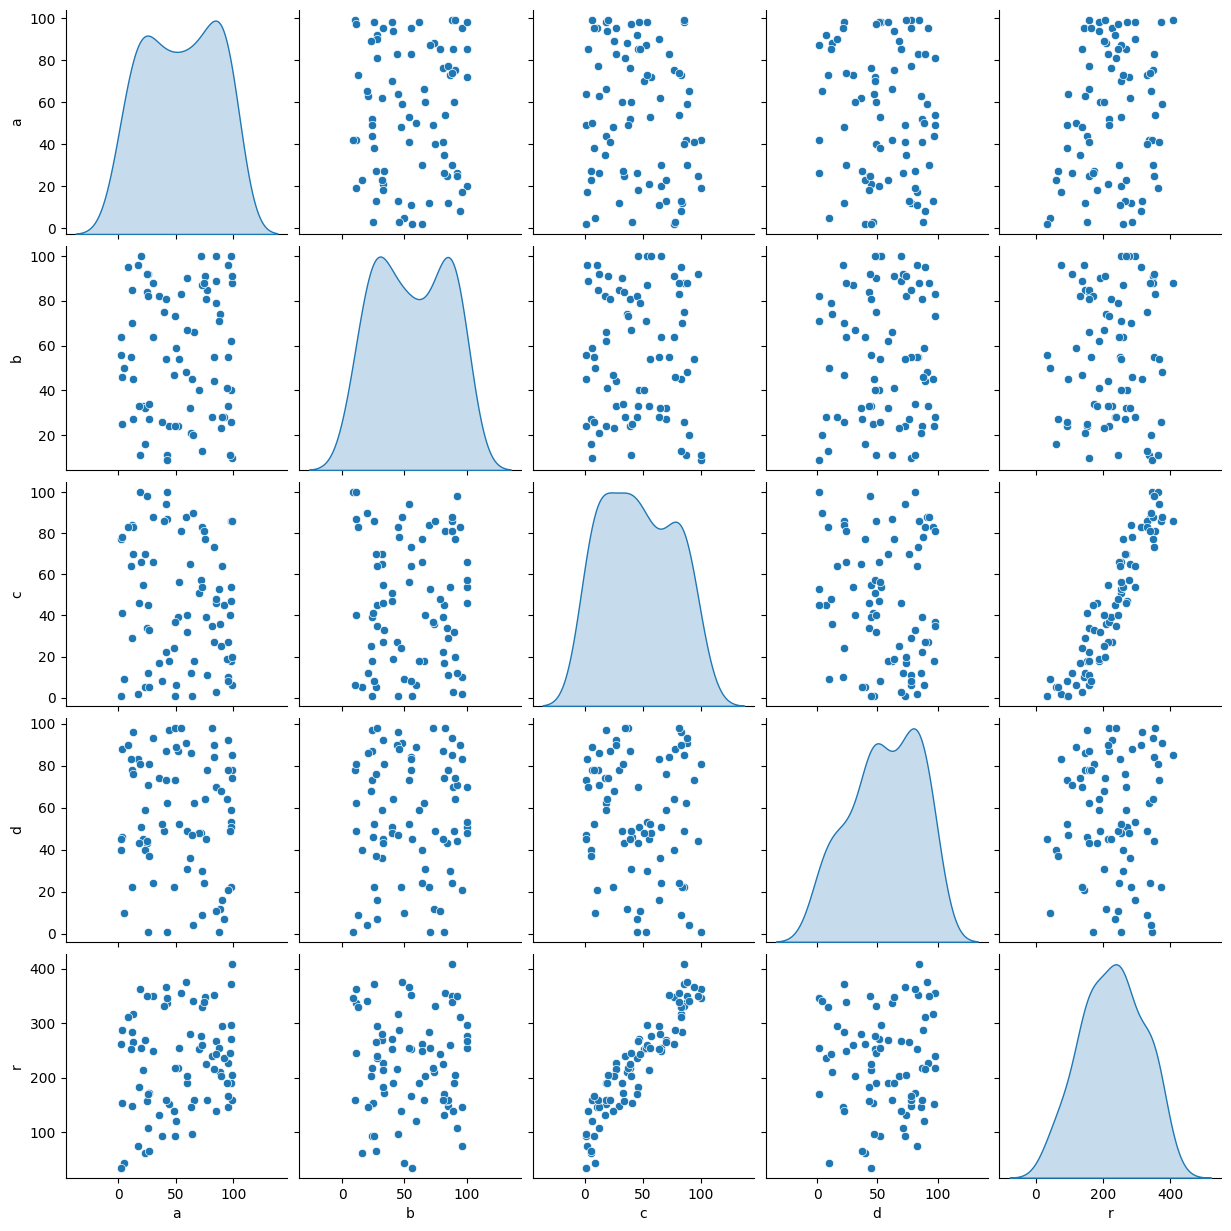

In [61]:
sns.pairplot(
    train_dataset[["a", "b", "c", "d", "r"]], 
    diag_kind="kde"
    )

In [62]:
train_stats = train_dataset.describe()
train_stats.pop("r")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
a,80.0,54.0125,31.221339,2.0,25.75,53.5,83.50,99.0
b,80.0,55.9250,28.432365,9.0,28.00,55.0,83.25,100.0
c,80.0,46.1875,30.096509,1.0,18.75,45.0,74.00,100.0
d,80.0,56.1125,28.319155,1.0,39.25,56.0,81.00,98.0


In [63]:
train_labels = train_dataset.pop('r')
test_labels = test_dataset.pop('r')

In [64]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
   
  model.compile(loss='mse',
    optimizer=optimizer,
    metrics=['mae', 'mse'])
    
  return model

In [65]:
model = build_model()


/workspace/UPSLP-Chatbot/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


array([[ 4.046783 ],
       [ 5.5497766],
       [ 3.7657888],
       [ 6.0777006],
       [ 7.494675 ],
       [ 6.0068054],
       [ 1.371237 ],
       [ 5.5962505],
       [-6.2037463],
       [-2.6126318]], dtype=float32)

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)



In [82]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), early_stop])


.....................

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
16,51.338833,6.417372,51.338833,31.561386,4.793412,31.561386,16
17,23.754580,4.037391,23.754580,26.391424,4.304231,26.391424,17
18,12.991775,2.766084,12.991775,10.286125,2.570323,10.286125,18
19,10.114012,2.437611,10.114012,8.769643,2.338727,8.769643,19
20,9.772768,2.411907,9.772768,12.284855,2.883735,12.284855,20


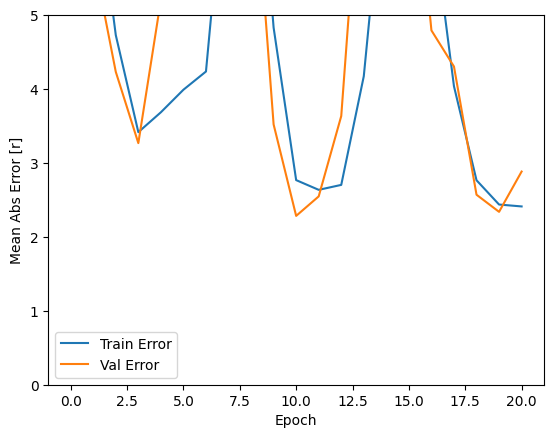

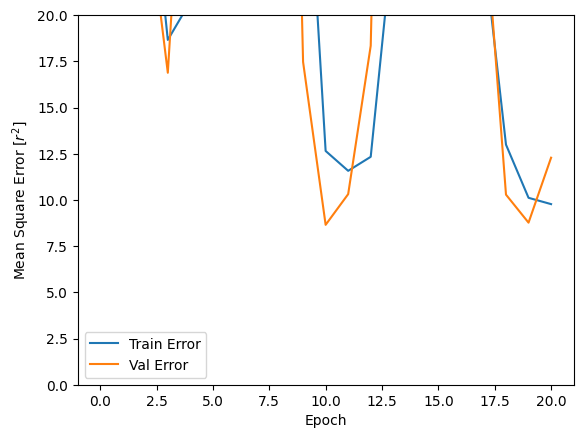

In [84]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [r]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$r^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

/workspace/UPSLP-Chatbot/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



.............................................................................................

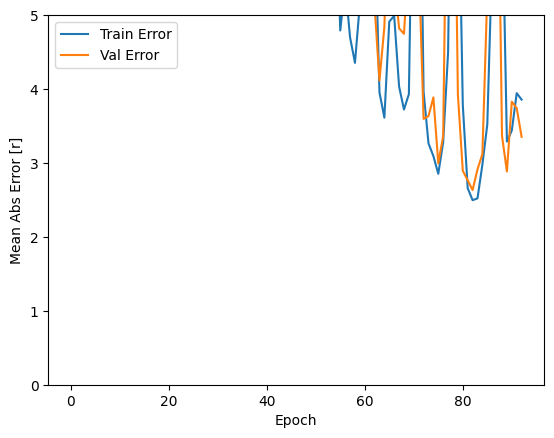

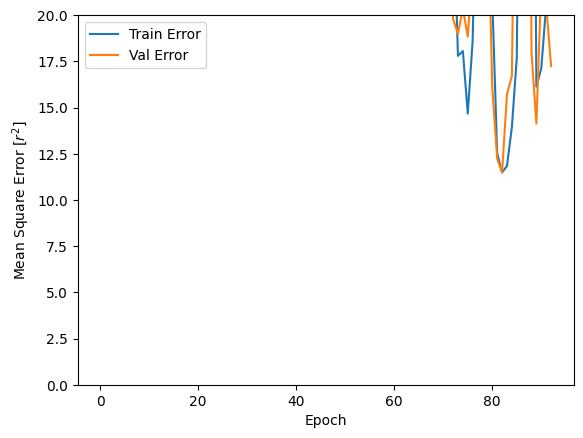

In [85]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [86]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} r".format(mae))

1/1 - 0s - 32ms/step - loss: 31.3721 - mae: 4.9938 - mse: 31.3721
Testing set Mean Abs Error:  4.99 r


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


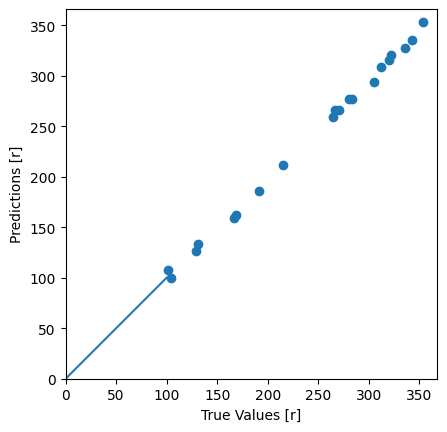

In [87]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [r]')
plt.ylabel('Predictions [r]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

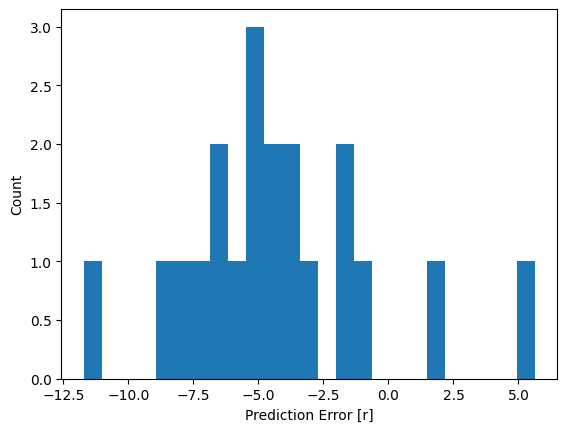

In [88]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [r]")
_ = plt.ylabel("Count")